In [2]:
### import keras
from keras.preprocessing.image import ImageDataGenerator
from keras import layers
from keras import models
from keras import optimizers
import matplotlib.pyplot as plt
from keras.applications import VGG16

/usr/local/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
train_folder = './train/'
val_folder = './val/'
test_folder = './test/'

## 1. Keras 生成器
当数据文件过大时，我们不能将数据直接全部加载到内存，这是需要Keras的**生成器**机制

**生成器**的作用是在训练的过程中不停的给模型喂数据，同时保证内存中只保存少量的数据

keras中使用**ImageDataGenerator**定义生成器的类

```py
keras.preprocessing.image.ImageDataGenerator(featurewise_center=False, 
                                             samplewise_center=False, 
                                             featurewise_std_normalization=False, 
                                             samplewise_std_normalization=False, 
                                             zca_whitening=False, 
                                             zca_epsilon=1e-06, 
                                             rotation_range=0.0, 
                                             width_shift_range=0.0, 
                                             height_shift_range=0.0, 
                                             brightness_range=None, 
                                             shear_range=0.0, 
                                             zoom_range=0.0, 
                                             channel_shift_range=0.0, 
                                             fill_mode='nearest', 
                                             cval=0.0, 
                                             horizontal_flip=False, 
                                             vertical_flip=False, 
                                             rescale=None, 
                                             preprocessing_function=None, 
                                             data_format=None, 
                                             validation_split=0.0)
                                             
```

ImageDataGenerator里面的参数主要用于数据扩充（数据增强），之后会讲解数据增强的作用


In [3]:
train_data_gen = ImageDataGenerator(rescale=1./255)
val_data_gen = ImageDataGenerator(rescale=1./255)
test_data_gen = ImageDataGenerator(rescale=1./255)

### 1.1 flow_from_directory函数

```py
flow_from_directory(directory, 
            target_size=(256, 256), 
            color_mode='rgb',
            classes=None,
            class_mode='categorical', 
            batch_size=32, 
            shuffle=True, 
            seed=None, 
            save_to_dir=None, 
            save_prefix='', 
            save_format='png', 
            follow_links=False, 
            subset=None, 
            interpolation='nearest')
```

我们要使用的参数

**batch_size**：取出每个batch中图片的个数，图片越少，计算越快，显存消耗越低，但是模型训练过程容易不稳定。常见的策略是从2^n中选择满足显存需求的最大的值

**target_size**：batch中图像的尺寸，当前数据集不需要resize，直接选择输入图片的尺寸(66, 66)即可

**class_mode**：默认是categorical，即当前数据是多累数据，如果实二分类，其值应该是‘binary’

In [6]:
train_generator = train_data_gen.flow_from_directory(train_folder, 
                                                     target_size=(66, 66), 
                                                     batch_size=128, 
                                                     class_mode='categorical')
val_generator = val_data_gen.flow_from_directory(val_folder, 
                                                     target_size=(66, 66), 
                                                     batch_size=128, 
                                                     class_mode='categorical')
test_generator = test_data_gen.flow_from_directory(test_folder, 
                                                     target_size=(66, 66), 
                                                     batch_size=128, 
                                                     class_mode='categorical')

Found 8594 images belonging to 80 classes.
Found 1600 images belonging to 80 classes.
Found 1600 images belonging to 80 classes.


## 模型搭建

自创模型：

1. 堆积卷积操作（Conv2D）和最大池化操作（MaxPooling2D），第一层需要指定输入图像的尺寸和通道数
2. Flatten()用于将Feature Map展开成特征向量
3. 之后接全连接层和激活层，注意多分类应该使用softmax激活函数

```py
keras.layers.Conv2D(filters, 
            kernel_size, 
            strides=(1, 1), 
            padding='valid', 
            data_format=None, 
            dilation_rate=(1, 1), 
            activation=None, 
            use_bias=True, 
            kernel_initializer='glorot_uniform',
            bias_initializer='zeros', 
            kernel_regularizer=None,
            bias_regularizer=None, 
            activity_regularizer=None, 
            kernel_constraint=None, 
            bias_constraint=None)
```

```py
keras.layers.MaxPooling2D(pool_size=(2, 2), 
            strides=None, 
            padding='valid', 
            data_format=None)
```

自行搭建网络的几个技巧

1. 通道数的数量取2^n；
2. 每次MaxPooling之后通道数*2；
5. 最后一层Feature Map的尺寸不宜太大也不宜太小。
3. 输出层和Flatten（）层往往需要加最少一个隐层用于过渡特征；
4. 根据计算Flatten（）层的节点数量设计隐层节点的个数；


或者使用经典模型：

* LeNet
* AlexNet
* VGG-16/VGG-19
* GoogLeNet
* Residual Net
* SENet
* DenseNet

选择模型的技巧：根据任务的复杂度选择最合适的模型，简单任务可以选择VGG等比较浅的网络，目前复杂任务主流的选择是比较深的Residual Net

In [7]:
model_simple = models.Sequential()
model_simple.add(layers.Conv2D(32, (3,3), padding='same', activation='relu', input_shape = (66,66,3)))
model_simple.add(layers.MaxPooling2D((2,2)))
model_simple.add(layers.Conv2D(64, (3,3), padding='same', activation='relu'))
model_simple.add(layers.MaxPooling2D((2,2)))
model_simple.add(layers.Conv2D(128, (3,3), padding='same', activation='relu'))
model_simple.add(layers.MaxPooling2D((2,2)))
model_simple.add(layers.Flatten())
model_simple.add(layers.Dense(1024, activation='relu'))
model_simple.add(layers.Dense(80, activation='softmax'))

In [8]:
model_simple.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 66, 66, 32)        896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 33, 33, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 33, 33, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 128)       73856     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 8, 8, 128)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
__________

In [9]:
model_simple.compile(loss='categorical_crossentropy', optimizer=optimizers.Adagrad(lr=0.01), metrics=['acc'])

In [10]:
history_simple = model_simple.fit_generator(train_generator, 
                              steps_per_epoch=128, 
                              epochs=20, 
                              validation_data=val_generator)

Epoch 1/20
128/128 [==============================] - 12s 90ms/step - loss: 4.0522 - acc: 0.1014 - val_loss: 2.9788 - val_acc: 0.2500
Epoch 2/20
128/128 [==============================] - 7s 53ms/step - loss: 2.0585 - acc: 0.4661 - val_loss: 1.6802 - val_acc: 0.5819
Epoch 3/20
128/128 [==============================] - 6s 49ms/step - loss: 0.8325 - acc: 0.7825 - val_loss: 1.1667 - val_acc: 0.7362
Epoch 4/20
128/128 [==============================] - 6s 46ms/step - loss: 0.2568 - acc: 0.9385 - val_loss: 1.0669 - val_acc: 0.8019
Epoch 5/20
128/128 [==============================] - 6s 46ms/step - loss: 0.0698 - acc: 0.9866 - val_loss: 1.0767 - val_acc: 0.8181
Epoch 6/20
128/128 [==============================] - 6s 49ms/step - loss: 0.0164 - acc: 0.9987 - val_loss: 1.1737 - val_acc: 0.8200
Epoch 7/20
128/128 [==============================] - 6s 48ms/step - loss: 0.0069 - acc: 0.9996 - val_loss: 1.2355 - val_acc: 0.8200
Epoch 8/20
128/128 [==============================] - 6s 50ms/step -

In [11]:
acc = history_simple.history['acc']
val_acc = history_simple.history['val_acc']
loss = history_simple.history['loss']
val_loss = history_simple.history['val_loss']

epochs = range(1, len(acc)+1)

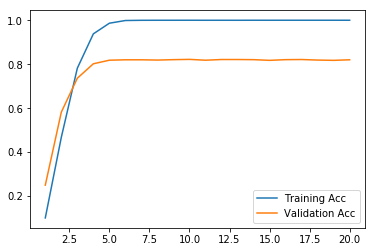

In [12]:
plt.plot(epochs, acc, label='Training Acc')
plt.plot(epochs, val_acc, label='Validation Acc')
plt.legend()

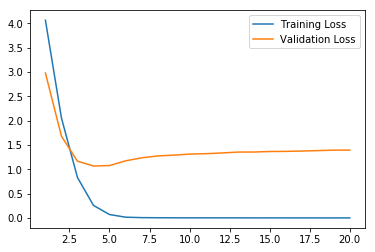

In [13]:
plt.plot(epochs, loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.legend()

In [14]:
model_simple.evaluate_generator(test_generator)

[1.2819558668136597, 0.8275]

## 3. 过拟合

通过上面的分析，我们发现模型严重过拟合了，我们可以采用以下策略减轻过拟合的问题：

1. Dropout
2. 早停
3. 正则化
4. 数据增强

### 3.1 Dropout

一些经验：

1. Dropout放到后面几层，尤其是全连接层；
2. 丢失率为0.25效果往往比较好。

Dropout太少或者丢失率太小的话不能有效缓解过拟合，Dropout太多或者丢失率太大容易导致模型不收敛。

没有太固定的套路决定Dropout怎么设置，更好的策略是根据验证机调整

In [37]:
model_dropout = models.Sequential()
model_dropout.add(layers.Conv2D(32, (3,3), padding='same', activation='relu', input_shape = (66,66,3)))
model_dropout.add(layers.MaxPooling2D((2,2)))
model_dropout.add(layers.Conv2D(64, (3,3), padding='same', activation='relu'))
model_dropout.add(layers.MaxPooling2D((2,2)))
model_dropout.add(layers.Dropout(0.25))
model_dropout.add(layers.Conv2D(128, (3,3), padding='same', activation='relu'))
model_dropout.add(layers.MaxPooling2D((2,2)))
model_dropout.add(layers.Dropout(0.25))
model_dropout.add(layers.Flatten())
model_dropout.add(layers.Dense(1024, activation='relu'))
model_dropout.add(layers.Dropout(0.25))
model_dropout.add(layers.Dense(80, activation='softmax'))

In [38]:
model_dropout.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 66, 66, 32)        896       
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 33, 33, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 33, 33, 64)        18496     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 16, 16, 128)       73856     
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 8, 8, 128)         0         
__________

In [39]:
model_dropout.compile(loss='categorical_crossentropy', optimizer=optimizers.Adagrad(lr=0.01), metrics=['acc'])
history_dropout = model_dropout.fit_generator(train_generator, 
                              steps_per_epoch=128, 
                              epochs=20, 
                              validation_data=val_generator)

Epoch 1/20
128/128 [==============================] - 7s 51ms/step - loss: 4.0397 - acc: 0.0814 - val_loss: 3.1852 - val_acc: 0.2238
Epoch 2/20
128/128 [==============================] - 6s 50ms/step - loss: 2.5751 - acc: 0.3361 - val_loss: 2.2123 - val_acc: 0.4294
Epoch 3/20
128/128 [==============================] - 6s 49ms/step - loss: 1.6246 - acc: 0.5673 - val_loss: 1.7204 - val_acc: 0.5781
Epoch 4/20
128/128 [==============================] - 6s 48ms/step - loss: 0.9945 - acc: 0.7293 - val_loss: 1.2534 - val_acc: 0.7131
Epoch 5/20
128/128 [==============================] - 6s 48ms/step - loss: 0.6411 - acc: 0.8269 - val_loss: 1.1056 - val_acc: 0.7575
Epoch 6/20
128/128 [==============================] - 6s 48ms/step - loss: 0.3868 - acc: 0.8924 - val_loss: 1.0318 - val_acc: 0.7931
Epoch 7/20
128/128 [==============================] - 6s 47ms/step - loss: 0.2558 - acc: 0.9287 - val_loss: 1.0298 - val_acc: 0.8087
Epoch 8/20
128/128 [==============================] - 6s 48ms/step - 

In [40]:
acc = history_dropout.history['acc']
val_acc = history_dropout.history['val_acc']
loss = history_dropout.history['loss']
val_loss = history_dropout.history['val_loss']

epochs = range(1, len(acc)+1)

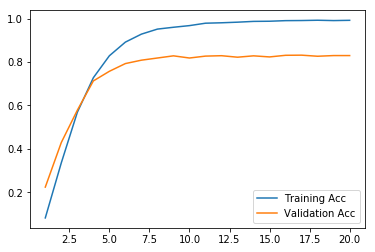

In [41]:
plt.plot(epochs, acc, label='Training Acc')
plt.plot(epochs, val_acc, label='Validation Acc')
plt.legend()

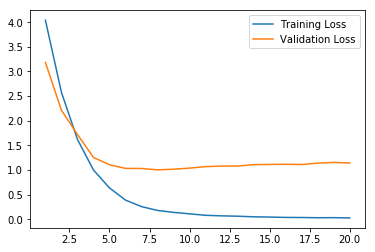

In [42]:
plt.plot(epochs, loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.legend()

In [43]:
model_dropout.evaluate_generator(test_generator)

[1.018291893005371, 0.83375]

## 3.2 数据扩充

keras提供在调用ImageDataGenerator类的时候添加数据扩充策略

```py
keras.preprocessing.image.ImageDataGenerator(featurewise_center=False, 
                                             samplewise_center=False, 
                                             featurewise_std_normalization=False, 
                                             samplewise_std_normalization=False, 
                                             zca_whitening=False, 
                                             zca_epsilon=1e-06, 
                                             rotation_range=0.0, 
                                             width_shift_range=0.0, 
                                             height_shift_range=0.0, 
                                             brightness_range=None, 
                                             shear_range=0.0, 
                                             zoom_range=0.0, 
                                             channel_shift_range=0.0, 
                                             fill_mode='nearest', 
                                             cval=0.0, 
                                             horizontal_flip=False, 
                                             vertical_flip=False, 
                                             rescale=None, 
                                             preprocessing_function=None, 
                                             data_format=None, 
                                             validation_split=0.0)
                                             
```

数据扩充的几点思考：

1. 扩充策略的设置要建立在对数据集充分的观测和理解上；
2. 正确的扩充策略能增加样本数量，大幅减轻过拟合的问题；
3. 错误的扩充策略很有可能导致模型不好收敛，更严重的问题是使训练集和测试集的分布更加不一致，加剧过拟合的问题；
4. 往往开发者需要根据业务场景自行实现扩充策略

In [44]:
train_data_gen_aug = ImageDataGenerator(rescale=1./255,
                                        horizontal_flip = True, 
                                        zoom_range = 0.1,
                                       width_shift_range= 0.1,
                                       height_shift_range=0.1,
                                       shear_range=0.1,
                                       rotation_range=5)
train_generator_aug = train_data_gen_aug.flow_from_directory(train_folder, 
                                                     target_size=(66, 66), 
                                                     batch_size=128, 
                                                     class_mode='categorical')

Found 8594 images belonging to 80 classes.


In [45]:
model_dropout_aug = models.Sequential()
model_dropout_aug.add(layers.Conv2D(32, (3,3), padding='same', activation='relu', input_shape = (66,66,3)))
model_dropout_aug.add(layers.MaxPooling2D((2,2)))
model_dropout_aug.add(layers.Conv2D(64, (3,3), padding='same', activation='relu'))
model_dropout_aug.add(layers.MaxPooling2D((2,2)))
model_dropout.add(layers.Dropout(0.25))
model_dropout_aug.add(layers.Conv2D(128, (3,3), padding='same', activation='relu'))
model_dropout_aug.add(layers.MaxPooling2D((2,2)))
model_dropout_aug.add(layers.Dropout(0.25))
model_dropout_aug.add(layers.Flatten())
model_dropout_aug.add(layers.Dense(1024, activation='relu'))
model_dropout_aug.add(layers.Dropout(0.25))
model_dropout_aug.add(layers.Dense(80, activation='softmax'))

In [46]:
model_dropout_aug.compile(loss='categorical_crossentropy', optimizer=optimizers.Adagrad(lr=0.01), metrics=['acc'])
history_dropout_aug = model_dropout_aug.fit_generator(train_generator_aug, 
                              steps_per_epoch=128, 
                              epochs=200, 
                              validation_data=val_generator)

Epoch 1/200
128/128 [==============================] - 17s 136ms/step - loss: 4.0259 - acc: 0.0810 - val_loss: 3.3218 - val_acc: 0.1787
Epoch 2/200
128/128 [==============================] - 17s 131ms/step - loss: 2.9262 - acc: 0.2534 - val_loss: 2.5636 - val_acc: 0.3519
Epoch 3/200
128/128 [==============================] - 17s 130ms/step - loss: 2.3618 - acc: 0.3791 - val_loss: 2.3972 - val_acc: 0.3969
Epoch 4/200
128/128 [==============================] - 16s 129ms/step - loss: 1.9685 - acc: 0.4737 - val_loss: 1.8225 - val_acc: 0.5156
Epoch 5/200
128/128 [==============================] - 17s 134ms/step - loss: 1.6555 - acc: 0.5474 - val_loss: 1.6301 - val_acc: 0.5837
Epoch 6/200
128/128 [==============================] - 17s 131ms/step - loss: 1.4281 - acc: 0.6016 - val_loss: 1.7168 - val_acc: 0.5681
Epoch 7/200
128/128 [==============================] - 17s 136ms/step - loss: 1.2404 - acc: 0.6488 - val_loss: 1.4457 - val_acc: 0.6319
Epoch 8/200
128/128 [===========================

Epoch 61/200
128/128 [==============================] - 17s 134ms/step - loss: 0.0960 - acc: 0.9714 - val_loss: 1.0370 - val_acc: 0.8475
Epoch 62/200
128/128 [==============================] - 17s 133ms/step - loss: 0.0914 - acc: 0.9725 - val_loss: 1.0537 - val_acc: 0.8456
Epoch 63/200
128/128 [==============================] - 17s 132ms/step - loss: 0.0931 - acc: 0.9729 - val_loss: 1.0934 - val_acc: 0.8337
Epoch 64/200
128/128 [==============================] - 17s 133ms/step - loss: 0.0885 - acc: 0.9731 - val_loss: 1.0723 - val_acc: 0.8363
Epoch 65/200
128/128 [==============================] - 17s 132ms/step - loss: 0.0794 - acc: 0.9770 - val_loss: 1.0345 - val_acc: 0.8475
Epoch 66/200
128/128 [==============================] - 17s 133ms/step - loss: 0.0888 - acc: 0.9742 - val_loss: 1.0473 - val_acc: 0.8481
Epoch 67/200
128/128 [==============================] - 17s 133ms/step - loss: 0.0814 - acc: 0.9761 - val_loss: 1.0505 - val_acc: 0.8488
Epoch 68/200
128/128 [===================

128/128 [==============================] - 18s 139ms/step - loss: 0.0240 - acc: 0.9921 - val_loss: 1.1786 - val_acc: 0.8569
Epoch 180/200
128/128 [==============================] - 18s 142ms/step - loss: 0.0276 - acc: 0.9922 - val_loss: 1.1864 - val_acc: 0.8550
Epoch 181/200
128/128 [==============================] - 18s 139ms/step - loss: 0.0257 - acc: 0.9924 - val_loss: 1.1583 - val_acc: 0.8575
Epoch 182/200
128/128 [==============================] - 18s 140ms/step - loss: 0.0270 - acc: 0.9918 - val_loss: 1.1769 - val_acc: 0.8550
Epoch 183/200
128/128 [==============================] - 18s 139ms/step - loss: 0.0252 - acc: 0.9928 - val_loss: 1.1830 - val_acc: 0.8525
Epoch 184/200
128/128 [==============================] - 18s 140ms/step - loss: 0.0253 - acc: 0.9925 - val_loss: 1.2127 - val_acc: 0.8450
Epoch 185/200
128/128 [==============================] - 18s 141ms/step - loss: 0.0236 - acc: 0.9933 - val_loss: 1.1794 - val_acc: 0.8481
Epoch 186/200
128/128 [=========================

In [47]:
acc = history_dropout_aug.history['acc']
val_acc = history_dropout_aug.history['val_acc']
loss = history_dropout_aug.history['loss']
val_loss = history_dropout_aug.history['val_loss']

epochs = range(1, len(acc)+1)

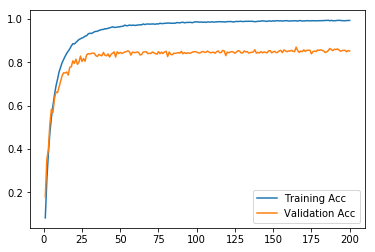

In [48]:
plt.plot(epochs, acc, label='Training Acc')
plt.plot(epochs, val_acc, label='Validation Acc')
plt.legend()

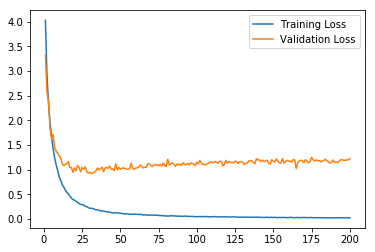

In [49]:
plt.plot(epochs, loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.legend()

In [50]:
model_dropout_aug.evaluate_generator(test_generator)

[1.1169185400009156, 0.84875]

## 4. 迁移学习

迁移学习是将训练好的任务A（最常用的是ImageNet）的模型用于当前任务的网络的初始化，然后在自己的数据上进行微调。该方法在数据集比较小的任务上往往效果很好。

```py
keras.applications.vgg16.VGG16(include_top=True, 
            weights='imagenet', 
            input_tensor=None, 
            input_shape=None, 
            pooling=None, 
            classes=1000)
```
**weights**：选择初始化的数据集，执行时会自动将模型文件下载到本地，None表示随机初始化；

**include_top**：由于我们的输出层和imageNet不一样，所以应该选择False；

**input_shape**：输入图像的尺寸，建议和网络结构相同（VGG16是224），所以我们需要更改生成器的参数值。

Keras提供用户自定义迁移学习时哪些层可以微调，哪些层不需要微调，通过layer.trainable设置

Keras使用迁移学习提供的模型往往比较深，容易产生梯度消失或者梯度爆炸的问题，建议添加BN层

最好的策略是选择好适合自己任务的网络后自己使用ImageNet数据集进行训练

In [19]:
train_generator_vgg16 = train_data_gen.flow_from_directory(train_folder, 
                                                     target_size = (224, 224), # 根据VGG16的网络结构放大了输入图片
                                                     batch_size = 32, #OOM, 故缩小了Batch Size
                                                     class_mode = 'categorical')
val_generator_vgg16 = val_data_gen.flow_from_directory(val_folder, 
                                                     target_size = (224, 224), 
                                                     batch_size = 32, 
                                                     class_mode = 'categorical')
test_generator_vgg16 = test_data_gen.flow_from_directory(test_folder, 
                                                     target_size = (224, 224), 
                                                     batch_size = 128, 
                                                     class_mode = 'categorical')

Found 8594 images belonging to 80 classes.
Found 1600 images belonging to 80 classes.
Found 1600 images belonging to 80 classes.


### 4.1 先看看使用VGG-16随机初始化的结果

In [52]:
model_rand_VGG16 = models.Sequential()
rand_VGG16 = VGG16(weights=None, include_top=False, input_shape=(224,224,3))
model_rand_VGG16.add(rand_VGG16)
model_rand_VGG16.add(layers.Flatten())
model_rand_VGG16.add(layers.Dense(1024, activation='relu'))
model_rand_VGG16.add(layers.Dropout(0.25))
model_rand_VGG16.add(layers.BatchNormalization()) # 梯度爆炸
model_rand_VGG16.add(layers.Dense(80, activation='softmax'))
model_rand_VGG16.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_5 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_9 (Dense)              (None, 1024)              25691136  
_________________________________________________________________
dropout_13 (Dropout)         (None, 1024)              0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 1024)              4096      
_________________________________________________________________
dense_10 (Dense)             (None, 80)                82000     
Total params: 40,491,920
Trainable params: 40,489,872
Non-trainable params: 2,048
____________________________________________________________

In [53]:
model_rand_VGG16.compile(loss='categorical_crossentropy', optimizer=optimizers.Adagrad(lr=0.01), metrics=['acc'])
history_rand_VGG16g = model_rand_VGG16.fit_generator(train_generator_vgg16, 
                              steps_per_epoch=128, 
                              epochs=50, 
                              validation_data = val_generator_vgg16)

Epoch 1/50
128/128 [==============================] - 49s 386ms/step - loss: 4.2843 - acc: 0.0474 - val_loss: 6.5366 - val_acc: 0.0125
Epoch 2/50
128/128 [==============================] - 48s 377ms/step - loss: 3.9928 - acc: 0.0711 - val_loss: 5.5207 - val_acc: 0.0125
Epoch 3/50
128/128 [==============================] - 47s 369ms/step - loss: 3.8453 - acc: 0.1008 - val_loss: 4.8519 - val_acc: 0.0125
Epoch 4/50
128/128 [==============================] - 47s 370ms/step - loss: 3.8783 - acc: 0.0920 - val_loss: 4.6725 - val_acc: 0.0163
Epoch 5/50
128/128 [==============================] - 47s 371ms/step - loss: 3.5315 - acc: 0.1511 - val_loss: 4.5646 - val_acc: 0.0175
Epoch 6/50
128/128 [==============================] - 47s 370ms/step - loss: 3.3834 - acc: 0.1805 - val_loss: 4.4622 - val_acc: 0.0144
Epoch 7/50
128/128 [==============================] - 47s 370ms/step - loss: 3.1980 - acc: 0.2248 - val_loss: 4.5511 - val_acc: 0.0156
Epoch 8/50
128/128 [==============================] - 4

In [54]:
acc = history_rand_VGG16g.history['acc']
val_acc = history_rand_VGG16g.history['val_acc']
loss = history_rand_VGG16g.history['loss']
val_loss = history_rand_VGG16g.history['val_loss']

epochs = range(1, len(acc)+1)

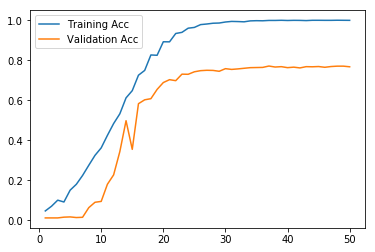

In [55]:
plt.plot(epochs, acc, label='Training Acc')
plt.plot(epochs, val_acc, label='Validation Acc')
plt.legend()

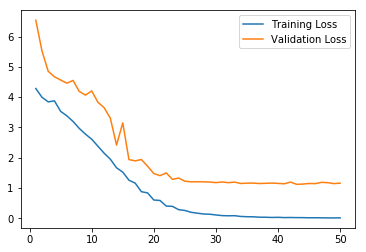

In [56]:
plt.plot(epochs, loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.legend()

In [57]:
model_rand_VGG16.evaluate_generator(test_generator_vgg16)

[1.1671059846878051, 0.75375]

### 4.2 train VGG16 with transfer learning

In [58]:
model_trans_VGG16 = models.Sequential()
trans_VGG16 = VGG16(weights='imagenet', include_top=False, input_shape=(224,224,3))
model_trans_VGG16.add(trans_VGG16)
model_trans_VGG16.add(layers.Flatten())
model_trans_VGG16.add(layers.Dense(1024, activation='relu'))
model_trans_VGG16.add(layers.BatchNormalization())
model_trans_VGG16.add(layers.Dropout(0.25))
model_trans_VGG16.add(layers.Dense(80, activation='softmax'))
model_trans_VGG16.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_6 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_11 (Dense)             (None, 1024)              25691136  
_________________________________________________________________
batch_normalization_2 (Batch (None, 1024)              4096      
_________________________________________________________________
dropout_14 (Dropout)         (None, 1024)              0         
_________________________________________________________________
dense_12 (Dense)             (None, 80)                82000     
Total params: 40,491,920
Trainable params: 40,489,872
Non-trainable params: 2,048
____________________________________________________________

In [59]:
model_trans_VGG16.compile(loss='categorical_crossentropy', optimizer=optimizers.Adagrad(lr=0.01), metrics=['acc'])
history_trans_VGG16g = model_trans_VGG16.fit_generator(train_generator_vgg16, 
                              steps_per_epoch=128, 
                              epochs=50, 
                              validation_data = val_generator_vgg16)

Epoch 1/50
128/128 [==============================] - 47s 366ms/step - loss: 4.1120 - acc: 0.0583 - val_loss: 8.6942 - val_acc: 0.0225
Epoch 2/50
128/128 [==============================] - 46s 359ms/step - loss: 3.7543 - acc: 0.0988 - val_loss: 8.4382 - val_acc: 0.0275
Epoch 3/50
128/128 [==============================] - 46s 361ms/step - loss: 3.6002 - acc: 0.1277 - val_loss: 10.4969 - val_acc: 0.0125
Epoch 4/50
128/128 [==============================] - 46s 360ms/step - loss: 3.2733 - acc: 0.1963 - val_loss: 15.9065 - val_acc: 0.0131
Epoch 5/50
128/128 [==============================] - 46s 361ms/step - loss: 2.8573 - acc: 0.2963 - val_loss: 6.3879 - val_acc: 0.0325
Epoch 6/50
128/128 [==============================] - 46s 361ms/step - loss: 2.6319 - acc: 0.3477 - val_loss: 5.1853 - val_acc: 0.0769
Epoch 7/50
128/128 [==============================] - 46s 361ms/step - loss: 2.2308 - acc: 0.4402 - val_loss: 3.9227 - val_acc: 0.1713
Epoch 8/50
128/128 [==============================] -

In [60]:
acc = history_trans_VGG16g.history['acc']
val_acc = history_trans_VGG16g.history['val_acc']
loss = history_trans_VGG16g.history['loss']
val_loss = history_trans_VGG16g.history['val_loss']

epochs = range(1, len(acc)+1)

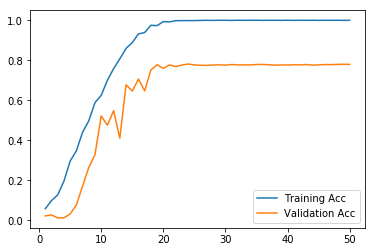

In [61]:
plt.plot(epochs, acc, label='Training Acc')
plt.plot(epochs, val_acc, label='Validation Acc')
plt.legend()

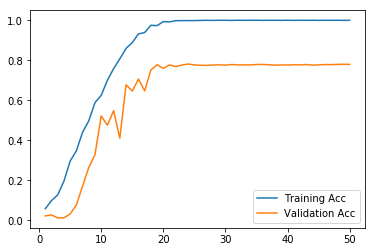

In [62]:
plt.plot(epochs, acc, label='Training Acc')
plt.plot(epochs, val_acc, label='Validation Acc')
plt.legend()

In [63]:
model_trans_VGG16.evaluate_generator(test_generator_vgg16)

[1.1362817412614823, 0.774375]

### 4.3 将VGG16固定为特征提取器

有时很我们需要冻结迁移学习的模型：如果一个模型是经过预训练的而另一部分随机初始化的，那么在训练期间将预训练的模型冻结可以**防止由于随机初始化的层产生的较大的梯度破坏已经训练好的特征提取器**

In [4]:
model_trans_VGG16_fixed = models.Sequential()
trans_VGG16 = VGG16(weights='imagenet', include_top=False, input_shape=(224,224,3))
model_trans_VGG16_fixed.add(trans_VGG16)
model_trans_VGG16_fixed.add(layers.Flatten())
model_trans_VGG16_fixed.add(layers.Dense(1024, activation='relu'))
model_trans_VGG16_fixed.add(layers.BatchNormalization())
model_trans_VGG16_fixed.add(layers.Dropout(0.25))
model_trans_VGG16_fixed.add(layers.Dense(80, activation='softmax'))
model_trans_VGG16.summary()

11599872/58889256 [====>.........................] - ETA: 1:37

KeyboardInterrupt: 

In [70]:
for layer in trans_VGG16.layers:
    layer.trainable = False

In [71]:
model_trans_VGG16_fixed.compile(loss='categorical_crossentropy', optimizer=optimizers.Adagrad(lr=0.01), metrics=['acc'])
history_trans_VGG16_fixed = model_trans_VGG16_fixed.fit_generator(train_generator_vgg16, 
                              steps_per_epoch=128, 
                              epochs=20, 
                              validation_data = val_generator_vgg16)

Epoch 1/20
128/128 [==============================] - 22s 175ms/step - loss: 1.8802 - acc: 0.5679 - val_loss: 15.4686 - val_acc: 0.0144
Epoch 2/20
128/128 [==============================] - 22s 169ms/step - loss: 0.8344 - acc: 0.7957 - val_loss: 1.0645 - val_acc: 0.7388
Epoch 3/20
128/128 [==============================] - 22s 169ms/step - loss: 0.2392 - acc: 0.9530 - val_loss: 0.5374 - val_acc: 0.8744
Epoch 4/20
128/128 [==============================] - 22s 169ms/step - loss: 0.1732 - acc: 0.9653 - val_loss: 0.4585 - val_acc: 0.8919
Epoch 5/20
128/128 [==============================] - 22s 169ms/step - loss: 0.0819 - acc: 0.9919 - val_loss: 0.4189 - val_acc: 0.9006
Epoch 6/20
128/128 [==============================] - 22s 169ms/step - loss: 0.0573 - acc: 0.9941 - val_loss: 0.4057 - val_acc: 0.9056
Epoch 7/20
128/128 [==============================] - 22s 169ms/step - loss: 0.0387 - acc: 0.9971 - val_loss: 0.3952 - val_acc: 0.9031
Epoch 8/20
128/128 [==============================] - 

In [72]:
acc = history_trans_VGG16_fixed.history['acc']
val_acc = history_trans_VGG16_fixed.history['val_acc']
loss = history_trans_VGG16_fixed.history['loss']
val_loss = history_trans_VGG16_fixed.history['val_loss']

epochs = range(1, len(acc)+1)

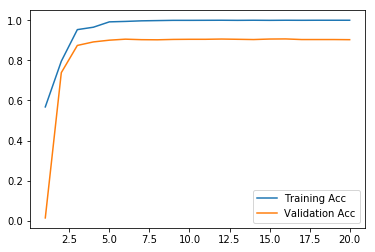

In [73]:
plt.plot(epochs, acc, label='Training Acc')
plt.plot(epochs, val_acc, label='Validation Acc')
plt.legend()

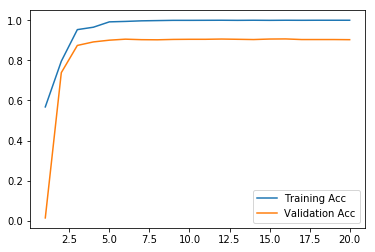

In [74]:
plt.plot(epochs, acc, label='Training Acc')
plt.plot(epochs, val_acc, label='Validation Acc')
plt.legend()

In [75]:
model_trans_VGG16_fixed.evaluate_generator(test_generator_vgg16)

[0.3866830364242196, 0.899375]

### 4.4 再加上数据扩充呢？

In [5]:
train_data_gen_aug = ImageDataGenerator(rescale=1./255,
                                        horizontal_flip = True, 
                                        zoom_range = 0.1,
                                       width_shift_range= 0.1,
                                       height_shift_range=0.1,
                                       shear_range=0.1,
                                       rotation_range=5)
train_generator_vgg16_aug = train_data_gen_aug.flow_from_directory(train_folder, 
                                                     target_size=(224, 224), 
                                                     batch_size=128, 
                                                     class_mode='categorical')

Found 8594 images belonging to 80 classes.


In [3]:
model_trans_VGG16_fixed_aug = models.Sequential()
trans_VGG16 = VGG16(weights='imagenet', include_top=False, input_shape=(224,224,3))
model_trans_VGG16_fixed_aug.add(trans_VGG16)
model_trans_VGG16_fixed_aug.add(layers.Flatten())
model_trans_VGG16_fixed_aug.add(layers.Dense(1024, activation='relu'))
model_trans_VGG16_fixed_aug.add(layers.BatchNormalization())
model_trans_VGG16_fixed_aug.add(layers.Dropout(0.25))
model_trans_VGG16_fixed_aug.add(layers.Dense(80, activation='softmax'))
model_trans_VGG16_fixed_aug.summary()

 3801088/58889256 [>.............................] - ETA: 19s

KeyboardInterrupt: 

In [8]:
for layer in trans_VGG16.layers:
    layer.trainable = False

In [9]:
model_trans_VGG16_fixed_aug.compile(loss='categorical_crossentropy', optimizer=optimizers.Adagrad(lr=0.01), metrics=['acc'])
history_trans_VGG16_fixed_aug = model_trans_VGG16_fixed_aug.fit_generator(train_generator_vgg16_aug, 
                              steps_per_epoch=128, 
                              epochs=20, 
                              validation_data = val_generator_vgg16)

Epoch 1/20
128/128 [==============================] - 123s 958ms/step - loss: 1.2663 - acc: 0.6905 - val_loss: 1.4110 - val_acc: 0.6562
Epoch 2/20
128/128 [==============================] - 118s 924ms/step - loss: 0.4192 - acc: 0.8956 - val_loss: 0.6110 - val_acc: 0.8456
Epoch 3/20
128/128 [==============================] - 119s 931ms/step - loss: 0.2386 - acc: 0.9435 - val_loss: 0.4809 - val_acc: 0.8788
Epoch 4/20
128/128 [==============================] - 120s 939ms/step - loss: 0.1559 - acc: 0.9666 - val_loss: 0.4370 - val_acc: 0.8906
Epoch 5/20
128/128 [==============================] - 120s 936ms/step - loss: 0.1184 - acc: 0.9747 - val_loss: 0.4056 - val_acc: 0.9019
Epoch 6/20
128/128 [==============================] - 118s 926ms/step - loss: 0.0852 - acc: 0.9848 - val_loss: 0.3889 - val_acc: 0.9075
Epoch 7/20
128/128 [==============================] - 124s 965ms/step - loss: 0.0705 - acc: 0.9875 - val_loss: 0.3721 - val_acc: 0.9163
Epoch 8/20
128/128 [============================

In [10]:
acc = history_trans_VGG16_fixed_aug.history['acc']
val_acc = history_trans_VGG16_fixed_aug.history['val_acc']
loss = history_trans_VGG16_fixed_aug.history['loss']
val_loss = history_trans_VGG16_fixed_aug.history['val_loss']

epochs = range(1, len(acc)+1)

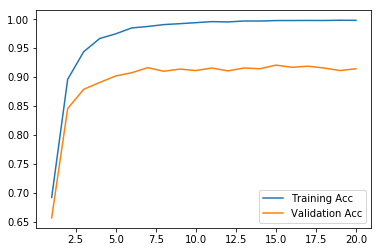

In [11]:
plt.plot(epochs, acc, label='Training Acc')
plt.plot(epochs, val_acc, label='Validation Acc')
plt.legend()

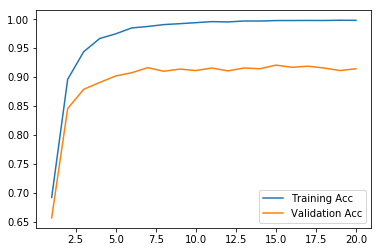

In [12]:
plt.plot(epochs, acc, label='Training Acc')
plt.plot(epochs, val_acc, label='Validation Acc')
plt.legend()

In [20]:
model_trans_VGG16_fixed_aug.evaluate_generator(test_generator_vgg16)

[0.36915452539920807, 0.91625]

### 4.5 分析

1. 迁移学习提供了能力非常强大的特征提取器；

2. Dropout和数据扩充有效缓解了过拟合的问题。

## 5. 总结

1. 自行搭建适合任务的网络：

    1.1 根据奥卡姆剃刀原理，模型尽可能小；
    
    1.2 模型轻微过拟合，为后面的正则操作留有空间。
    
    
2. 使用各种策略缓解过拟合：

    2.1 Early Stopping
    
    2.2 Dropout
    
    
3. 解决过拟合最有效的策略：数据扩充

    3.1 分析数据集，确定扩充的有效策略；
    
    3.2 使用Keras自带生成器类添加数据扩充策略；
    
    3.3 必要时自己编写数据扩充策略。
    
    
4. 迁移学习

    4.1 确定适用任务的迁移学习模型；
    
    4.2 判断是否冻结一些层；
    
    4.3 必要时根据自行搭建的模型在ImageNet上训练迁移学习模型
    
    

## 6. 练习

使用上面介绍的策略或尽情的调整你的模型吧

Hints：

1. 更合理的网络结构：网络层数，节点数量，卷积、池化、全连接的搭配；
2. 更好的缓解过拟合的策略：Dropout数量和位置，正则项
2. 更合理的数据扩充策略；
3. 更合适的迁移学习模型以及冻结策略；
5. 者其它自己了解的其它优化方向的策略（例如自适应学习率，L1正则，Attention等）